In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/joshuasir/datasets/main/all_agree_sampled.csv')

In [3]:
df,df_unseen = train_test_split(df,stratify=df['label_score'],random_state=42,test_size=.2)

In [4]:
import string
import re
import nltk

In [5]:
pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 7.5 MB/s 


In [6]:
df.dropna(inplace=True)
df_unseen.dropna(inplace=True)

In [7]:
df_train = df.drop(['label'],axis=1).copy()
df_unseen = df_unseen.drop(['label'],axis=1)

In [8]:
df_train['title'] = df_train['title'].apply(lambda x: x.strip())
df_unseen['title'] = df_unseen['title'].apply(lambda x: x.strip())

In [9]:
df_train.drop_duplicates(subset='title',inplace=True,ignore_index=True)
df_unseen.drop_duplicates(subset='title',inplace=True,ignore_index=True)

In [10]:
df_train['title'] = df_train['title'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
df_unseen['title'] = df_unseen['title'].apply(lambda x : ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))

In [11]:
df_train['title'] = df_train['title'].str.lower()
df_unseen['title'] = df_unseen['title'].str.lower()

In [12]:
df_train['title'] = df_train['title'].str.replace('https?:\/\/.*[\r\n]*', '')
df_train['title'] = df_train['title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_train['title'] = df_train['title'].str.replace('\d+', '')
df_train['title'] = df_train['title'].str.replace('[^\w\s]', '')

df_unseen['title'] = df_unseen['title'].str.replace('https?:\/\/.*[\r\n]*', '')
df_unseen['title'] = df_unseen['title'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
df_unseen['title'] = df_unseen['title'].str.replace('\d+', '')
df_unseen['title'] = df_unseen['title'].str.replace('[^\w\s]', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-pa

In [13]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.5 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 6.6 MB 9.1 MB/s 
     |████████████████████████████████| 596 kB 69.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
pip install SentencePiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 8.1 MB/s 


In [15]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [16]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, TFRobertaForSequenceClassification, BertTokenizer,XLMRobertaTokenizer,TFXLMRobertaForSequenceClassification,Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [17]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

In [18]:
tf.compat.v1.Session(config = config)

In [19]:
config = tf.compat.v1.ConfigProto(device_count ={'GPU': 0}) 
sess = tf.compat.v1.Session(config=config)

In [20]:
X = df_train[['title','label_score']].copy()
y = X.pop('label_score')

X_train,X_valid,y_train,y_valid = train_test_split(X,y,stratify=y,test_size=.2,random_state=42)

In [21]:
X_unseen = df_unseen[['title','label_score']].copy()
y_unseen = X_unseen.pop('label_score')

In [22]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [ ]:
def train(classifier,train=[],name='',graph=False):
    
    scoring = {
           'Precision': 'precision_macro',
           'Recall': 'recall_macro',
           'F1':'f1_macro',
           'ROC_AUC'  : 'roc_auc'
    }
    pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', classifier),
    ])

    score_dict = cross_validate(pipe, train[0], train[1],
                              cv=10,
                              scoring=scoring)

    scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
    scores = scores.append(pd.Series({ 
                                      'Model' : name,
                                      # 'Accuracy' : score_dict['test_Accuracy'].mean(),
                                      'Precision' : score_dict['test_Precision'].mean(),
                                      'Recall' : score_dict['test_Recall'].mean(),
                                      'F1' : score_dict['test_F1'].mean(),
                                      'ROC AUC' : score_dict['test_ROC_AUC'].mean()
    }),ignore_index=True)
 
    return scores

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer


models =  { "Decision Tree" : DecisionTreeClassifier(),
            "Random Forest" : RandomForestClassifier(),
            "XGBoost" : XGBClassifier(), 
            "LogisticRegression" : LogisticRegression(max_iter=1200), 
            "CatBoost" :CatBoostClassifier(verbose=False) ,
            'LGBM' : LGBMClassifier(),
            'KNeighbors' : KNeighborsClassifier(),
            'AdaBoost' : AdaBoostClassifier(),
            'MultinomialNB': MultinomialNB()
            }

scores = pd.DataFrame(columns=['Model','Precision','Recall','F1','ROC AUC'])
# probability = {}

for model in models:
  scores = scores.append(train(models[model],train=[pd.concat([X,X_unseen])['title'],pd.concat([y,y_unseen])],name=model))

In [ ]:
scores.sort_values('Precision',ascending=False).reset_index(drop=True)

,Model,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.868318,0.865897,0.865675,0.931551
1,Random Forest,0.855316,0.848737,0.848040,0.919781
2,CatBoost,0.846123,0.834592,0.833198,0.910289
3,MultinomialNB,0.840503,0.840249,0.840220,0.918098
4,LGBM,0.836950,0.829877,0.828974,0.897789
5,AdaBoost,0.816881,0.798383,0.795404,0.854764
6,XGBoost,0.816833,0.787814,0.782810,0.857001
7,Decision Tree,0.787040,0.785366,0.785046,0.785366
8,KNeighbors,0.782075,0.781593,0.781497,0.847124


In [23]:
import tensorflow_datasets as tfds
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer, RobertaTokenizer

def convert_sentence_to_features(sentence,tokenizer):
    return tokenizer.encode_plus(
        sentence,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )
def map_features_to_dict(input_ids_list, attention_masks_list, label_list,token_type_ids_list=[]):
    dict_={}
    if len(token_type_ids_list) > 0:
      dict_ = {
        'input_ids': input_ids_list,
        'token_type_ids' : token_type_ids_list,
        'attention_mask': attention_masks_list,
      }, label_list
    else:
      dict_ = {
        'input_ids': input_ids_list,
        'attention_mask': attention_masks_list,
      }, label_list
    return dict_
    
def encode_sentences(dataset,tokenizer):
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    tensor_dataset = []
    for message, label in tfds.as_numpy(dataset):
        bert_input = convert_sentence_to_features(message.decode(),tokenizer) 
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label]) 
        
        if 'token_type_ids' in bert_input:
          token_type_ids_list.append(bert_input['token_type_ids'])

    if len(token_type_ids_list) > 0:
      tensor_dataset = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list, token_type_ids_list))
    else:
      tensor_dataset = tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list))

    return tensor_dataset.map(map_features_to_dict)

In [24]:
BATCH_SIZE = 64
MAX_LENGTH = 60
SHUFFLE_BUFFER_SIZE=100

In [25]:
tensor_train = tf.data.Dataset.from_tensor_slices((X_train['title'].values,y_train.values))
tensor_valid = tf.data.Dataset.from_tensor_slices((X_valid['title'].values,y_valid.values))

In [26]:
tensor_unseen = tf.data.Dataset.from_tensor_slices((X_unseen['title'].values,y_unseen.values))

In [27]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

ds_train_encoded_bert = encode_sentences(tensor_train,tokenizer=tokenizer).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_bert = encode_sentences(tensor_valid,tokenizer=tokenizer).batch(BATCH_SIZE)

ds_unseen_encoded_bert = encode_sentences(tensor_unseen,tokenizer=tokenizer).batch(BATCH_SIZE)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [28]:
tokenizer2 = XLMRobertaTokenizer.from_pretrained('cahya/xlm-roberta-large-indonesian-NER')

ds_train_encoded_roberta = encode_sentences(tensor_train,tokenizer=tokenizer2).shuffle(SHUFFLE_BUFFER_SIZE).batch(int(BATCH_SIZE/2))
ds_valid_encoded_roberta = encode_sentences(tensor_valid,tokenizer=tokenizer2).batch(int(BATCH_SIZE/2))

ds_unseen_encoded_roberta = encode_sentences(tensor_unseen,tokenizer=tokenizer2).batch(int(BATCH_SIZE/2))

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
tokenizer3 = RobertaTokenizer.from_pretrained('cahya/roberta-base-indonesian-522M')

ds_train_encoded_roberta_base = encode_sentences(tensor_train,tokenizer=tokenizer3).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_roberta_base = encode_sentences(tensor_valid,tokenizer=tokenizer3).batch(BATCH_SIZE) 

ds_unseen_encoded_roberta_base = encode_sentences(tensor_unseen,tokenizer=tokenizer3).batch(BATCH_SIZE) 

Downloading:   0%|          | 0.00/905k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
tokenizer4 = BertTokenizer.from_pretrained('cahya/bert-base-indonesian-522M')

ds_train_encoded_cahya_bert = encode_sentences(tensor_train,tokenizer=tokenizer4).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
ds_valid_encoded_cahya_bert = encode_sentences(tensor_valid,tokenizer=tokenizer4).batch(BATCH_SIZE)

ds_unseen_encoded_cahya_bert = encode_sentences(tensor_unseen,tokenizer=tokenizer4).batch(BATCH_SIZE)

Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/468 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [94]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [95]:
result_table_valid = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

In [33]:
def plot_acc_loss(hist):
  hist = pd.DataFrame(hist.history)
  hist[['accuracy','val_accuracy']].plot()
  plt.show()
  hist[['loss','val_loss']].plot()
  plt.show()

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,make_scorer,precision_score,recall_score,plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(model,X,y,result_table,label='',batch_size=64,threshold=.5):
  plt.clf()
  score = model.predict(X, batch_size=batch_size, verbose=1)[0]
  result = (score > threshold).astype('int32')
  print(classification_report(y,result.ravel(), labels=[0,1]))
  print('Precision avg :', precision_score(y,result.ravel(),average='weighted'))
  print('Recall avg :', recall_score(y,result.ravel(),average='weighted'))
  
  matrix_confusion = confusion_matrix(y,result.ravel())
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
  plt.show()
  if(label!=''):
    result_table = draw_roc(y, result.ravel(),label,result_table)
  return result_table
  # plt.show()

In [35]:
def draw_roc( actual, probs,label,result_table ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    result_table = result_table.append({'classifiers':label,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc_score}, ignore_index=True)

    return result_table

In [36]:
model_path = 'best_model.tf'
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs): 
        print("val/train: {:.2f}".format(logs["val_loss"]/logs["loss"]))
        
import datetime, os

%load_ext tensorboard

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_acc', save_best_weight=True),
    # tensorboard_callback,
    # tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=.2, # multiply the learning rate by 0.2 (reduce by 5x)
    #                                               patience=4, verbose=1, # print out when learning rate goes down 
    #                                               min_lr=1e-7),
    # PrintValTrainRatioCallback()
]

In [37]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-11)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
EPOCHS = 10

In [ ]:
tf.keras.backend.clear_session()
model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1',hidden_dropout_prob=.6,num_labels=1)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train_encoded_bert,
                    epochs=50,
                    validation_data=ds_valid_encoded_bert,
                    callbacks=callbacks
                    )

Epoch 1/50
53/53 [==============================] - 74s 854ms/step - loss: 0.6610 - accuracy: 0.5578 - val_loss: 0.5091 - val_accuracy: 0.6985
Epoch 2/50
53/53 [==============================] - 41s 781ms/step - loss: 0.4937 - accuracy: 0.7618 - val_loss: 0.3343 - val_accuracy: 0.8504
Epoch 3/50
53/53 [==============================] - 41s 781ms/step - loss: 0.4045 - accuracy: 0.8181 - val_loss: 0.2754 - val_accuracy: 0.8834
Epoch 4/50
53/53 [==============================] - 41s 781ms/step - loss: 0.3572 - accuracy: 0.8514 - val_loss: 0.2495 - val_accuracy: 0.8857
Epoch 5/50
53/53 [==============================] - 41s 779ms/step - loss: 0.3339 - accuracy: 0.8606 - val_loss: 0.2244 - val_accuracy: 0.9058
Epoch 6/50
53/53 [==============================] - 41s 779ms/step - loss: 0.3218 - accuracy: 0.8647 - val_loss: 0.2115 - val_accuracy: 0.9164
Epoch 7/50
53/53 [==============================] - 41s 773ms/step - loss: 0.2867 - accuracy: 0.8821 - val_loss: 0.2141 - val_accuracy: 0.9093

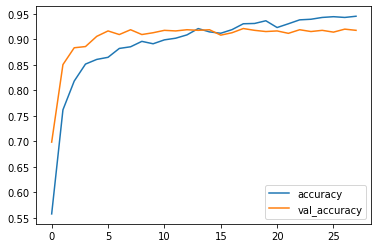

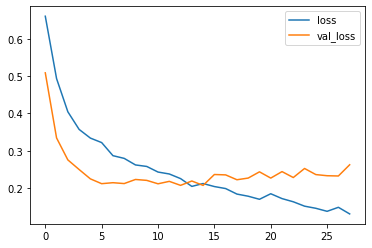

14/14 [==============================] - 3s 231ms/step
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       425
           1       0.96      0.88      0.92       424

    accuracy                           0.92       849
   macro avg       0.92      0.92      0.92       849
weighted avg       0.92      0.92      0.92       849

Precision avg : 0.9242996391488462
Recall avg : 0.9210836277974087


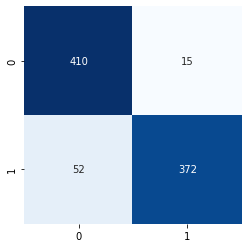

17/17 [==============================] - 4s 247ms/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       530
           1       0.95      0.85      0.90       531

    accuracy                           0.90      1061
   macro avg       0.91      0.90      0.90      1061
weighted avg       0.91      0.90      0.90      1061

Precision avg : 0.9079771462038088
Recall avg : 0.9029217719132894


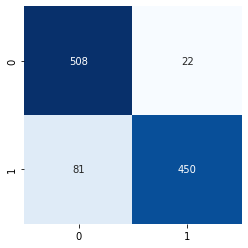

In [ ]:
plot_acc_loss(history)
result_table_valid = evaluation(model,ds_valid_encoded_bert,y_valid,result_table_valid,'IndoBERT-p1',64,.5)
result_table = evaluation(model,ds_unseen_encoded_bert,y_unseen,result_table,'IndoBERT-p1',64,.5)

In [ ]:
tf.keras.backend.clear_session()
model2 = TFXLMRobertaForSequenceClassification.from_pretrained('cahya/xlm-roberta-large-indonesian-NER',hidden_dropout_prob=.3,num_labels=1,from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on 

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [ ]:
history = model2.fit(ds_train_encoded_roberta,
                    epochs=50,
                    validation_data=ds_valid_encoded_roberta,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=8,restore_best_weights=True)]
                    )

Epoch 1/50
106/106 [==============================] - 193s 1s/step - loss: 0.6944 - accuracy: 0.5088 - val_loss: 0.6615 - val_accuracy: 0.6961
Epoch 2/50
106/106 [==============================] - 145s 1s/step - loss: 0.6658 - accuracy: 0.5422 - val_loss: 0.6498 - val_accuracy: 0.7126
Epoch 3/50
106/106 [==============================] - 145s 1s/step - loss: 0.5291 - accuracy: 0.7273 - val_loss: 0.5575 - val_accuracy: 0.7809
Epoch 4/50
106/106 [==============================] - 145s 1s/step - loss: 0.4337 - accuracy: 0.8022 - val_loss: 0.3149 - val_accuracy: 0.8799
Epoch 5/50
106/106 [==============================] - 145s 1s/step - loss: 0.3958 - accuracy: 0.8252 - val_loss: 0.2791 - val_accuracy: 0.8928
Epoch 6/50
106/106 [==============================] - 145s 1s/step - loss: 0.3465 - accuracy: 0.8552 - val_loss: 0.2667 - val_accuracy: 0.9105
Epoch 7/50
106/106 [==============================] - 145s 1s/step - loss: 0.3167 - accuracy: 0.8715 - val_loss: 0.2512 - val_accuracy: 0.9117

27/27 [==============================] - 16s 385ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       425
           1       0.94      0.92      0.93       424

    accuracy                           0.93       849
   macro avg       0.93      0.93      0.93       849
weighted avg       0.93      0.93      0.93       849

Precision avg : 0.9272079704160484
Recall avg : 0.9269729093050648


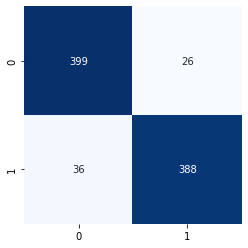

34/34 [==============================] - 13s 378ms/step
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       530
           1       0.92      0.89      0.91       531

    accuracy                           0.91      1061
   macro avg       0.91      0.91      0.91      1061
weighted avg       0.91      0.91      0.91      1061

Precision avg : 0.9098947287412099
Recall avg : 0.9095193213949104


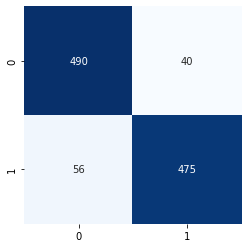

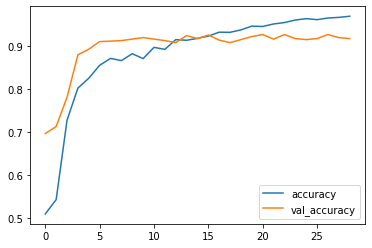

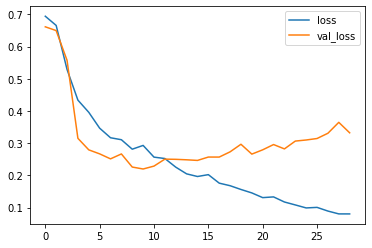

In [ ]:
result_table_valid = evaluation(model2,ds_valid_encoded_roberta,y_valid,result_table_valid,'cahya/XLM-RoBERTa-large',32,.5)
result_table = evaluation(model2,ds_unseen_encoded_roberta,y_unseen,result_table,'cahya/XLM-RoBERTa-large',32,.5)
plot_acc_loss(history)

 ### Bias cause

In [ ]:
pred = model2.predict(ds_unseen_encoded_roberta,batch_size=32, verbose=1)[0]

34/34 [==============================] - 13s 381ms/step


In [ ]:
result = (pred > .5).astype('int32')

In [ ]:
y_unseen[0]

1

In [ ]:
X_unseen[(result.ravel()!=y_unseen) & (y_unseen==1)]

,title
6,nyaman di bayern coutinho ogah kembali ke barc...
16,duarrr pengembala dan kerbau di tapteng tewas...
55,banyak gamer alami hambatan saat bermain
97,nikah putri baptis putin show striptis di depa...
100,queendom tanggapi kabar soal peserta bayar sen...
103,perwira polisi tuduh brigjend tni nyuri hp pra...
110,ide anies legalkan pkl di trotoar langgar unda...
132,gotong keranda mayat save kpk massa gejayan me...
140,pengacara fans produce x cemas kebenaran suli...
184,serempet pejalan kaki pemotor arogan ditangkap...


As expected a variant range topic of news contains unique keywords

In [ ]:
X_train['title'].str.contains('coutinho').sum()

0

In [ ]:
X_train['title'].str.contains('queendom').sum()

2

In [ ]:
X_train['title'].str.contains('gamer').sum()

1

In [ ]:
X_train['title'].str.contains('mobil').sum()

47

In [44]:
model3 = TFRobertaForSequenceClassification.from_pretrained('cahya/roberta-base-indonesian-522M',hidden_dropout_prob=.7,num_labels=1)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cahya/roberta-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [46]:
history3 = model3.fit(ds_train_encoded_roberta_base,
                    epochs=50,
                    validation_data=ds_valid_encoded_roberta_base,
                    callbacks=callbacks
                    )

Epoch 1/50
53/53 [==============================] - 68s 880ms/step - loss: 0.7181 - accuracy: 0.5035 - val_loss: 0.6859 - val_accuracy: 0.5006
Epoch 2/50
53/53 [==============================] - 42s 801ms/step - loss: 0.7173 - accuracy: 0.5112 - val_loss: 0.6739 - val_accuracy: 0.5006
Epoch 3/50
53/53 [==============================] - 43s 813ms/step - loss: 0.7161 - accuracy: 0.5159 - val_loss: 0.6583 - val_accuracy: 0.5018
Epoch 4/50
53/53 [==============================] - 43s 809ms/step - loss: 0.7094 - accuracy: 0.5174 - val_loss: 0.6434 - val_accuracy: 0.5159
Epoch 5/50
53/53 [==============================] - 43s 809ms/step - loss: 0.7094 - accuracy: 0.5121 - val_loss: 0.6164 - val_accuracy: 0.5583
Epoch 6/50
53/53 [==============================] - 43s 809ms/step - loss: 0.7044 - accuracy: 0.5254 - val_loss: 0.5803 - val_accuracy: 0.6784
Epoch 7/50
53/53 [==============================] - 43s 810ms/step - loss: 0.6850 - accuracy: 0.5413 - val_loss: 0.5316 - val_accuracy: 0.7656

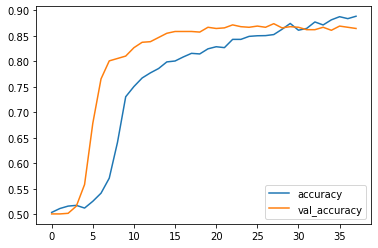

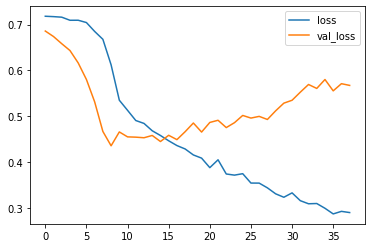

14/14 [==============================] - 3s 214ms/step
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       425
           1       0.87      0.88      0.87       424

    accuracy                           0.87       849
   macro avg       0.87      0.87      0.87       849
weighted avg       0.87      0.87      0.87       849

Precision avg : 0.8740735376751025
Recall avg : 0.8739693757361602


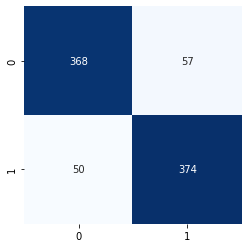

In [96]:
plot_acc_loss(history3)
result_table_valid = evaluation(model3,ds_valid_encoded_roberta_base,y_valid,result_table_valid,'cahya/RoBERTa-base',64,.5)

17/17 [==============================] - 4s 233ms/step
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       530
           1       0.87      0.85      0.86       531

    accuracy                           0.86      1061
   macro avg       0.86      0.86      0.86      1061
weighted avg       0.86      0.86      0.86      1061

Precision avg : 0.8588773812137076
Recall avg : 0.8586239396795476


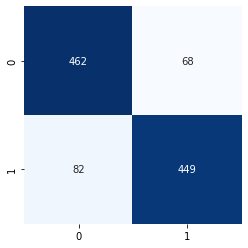

In [97]:
result_table = evaluation(model3,ds_unseen_encoded_roberta_base,y_unseen,result_table,'cahya/RoBERTa-base',64,.5)

In [52]:
tf.keras.backend.clear_session()
model4 = TFBertForSequenceClassification.from_pretrained('cahya/bert-base-indonesian-522M',hidden_dropout_prob=.6,num_labels=1)

Downloading:   0%|          | 0.00/520M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=9e-6, epsilon=1e-11),
              loss=loss,
              metrics=['accuracy'])

In [54]:
history4 = model4.fit(ds_train_encoded_cahya_bert,
                    epochs=50,
                    validation_data=ds_valid_encoded_cahya_bert,
                    callbacks=callbacks
                    )

Epoch 1/50
53/53 [==============================] - 63s 870ms/step - loss: 0.6944 - accuracy: 0.5047 - val_loss: 0.6656 - val_accuracy: 0.5029
Epoch 2/50
53/53 [==============================] - 42s 789ms/step - loss: 0.6737 - accuracy: 0.5351 - val_loss: 0.6043 - val_accuracy: 0.6349
Epoch 3/50
53/53 [==============================] - 43s 811ms/step - loss: 0.6240 - accuracy: 0.6206 - val_loss: 0.4731 - val_accuracy: 0.7703
Epoch 4/50
53/53 [==============================] - 42s 791ms/step - loss: 0.5233 - accuracy: 0.7217 - val_loss: 0.4177 - val_accuracy: 0.8092
Epoch 5/50
53/53 [==============================] - 43s 808ms/step - loss: 0.4659 - accuracy: 0.7789 - val_loss: 0.3684 - val_accuracy: 0.8433
Epoch 6/50
53/53 [==============================] - 43s 804ms/step - loss: 0.4346 - accuracy: 0.7989 - val_loss: 0.3446 - val_accuracy: 0.8575
Epoch 7/50
53/53 [==============================] - 43s 806ms/step - loss: 0.4105 - accuracy: 0.8163 - val_loss: 0.3383 - val_accuracy: 0.8740

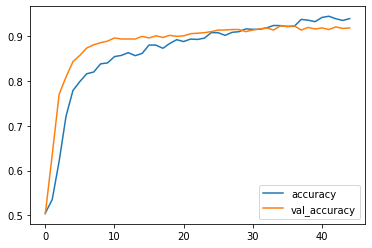

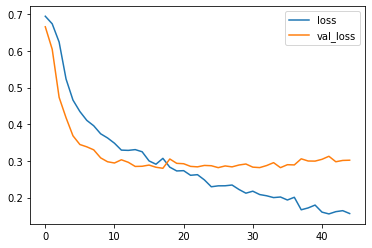

14/14 [==============================] - 3s 228ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       425
           1       0.93      0.91      0.92       424

    accuracy                           0.92       849
   macro avg       0.92      0.92      0.92       849
weighted avg       0.92      0.92      0.92       849

Precision avg : 0.923627858881423
Recall avg : 0.9234393404004712


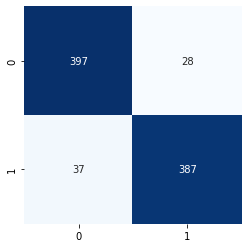

In [98]:
plot_acc_loss(history4)
result_table_valid = evaluation(model4,ds_valid_encoded_cahya_bert,y_valid,result_table_valid,'cahya/BERT-base',64,.5)

17/17 [==============================] - 4s 234ms/step
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       530
           1       0.91      0.87      0.89       531

    accuracy                           0.89      1061
   macro avg       0.89      0.89      0.89      1061
weighted avg       0.89      0.89      0.89      1061

Precision avg : 0.8903424066702171
Recall avg : 0.8897266729500471


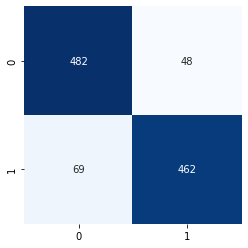

In [99]:
result_table = evaluation(model4,ds_unseen_encoded_cahya_bert,y_unseen,result_table,'cahya/BERT-base',64,.5)

In [102]:
result_table_valid.drop(result_table_valid.columns[0], axis=1, inplace=True)

In [103]:
result_table_valid.set_index('classifiers', inplace=True)

In [104]:
result_table_valid = result_table_valid.applymap(lambda x : [ float(i) for i in x.replace('[','').replace(']','').replace(',','').split(' ') if i!= ''] if isinstance(x, str) else x)

In [107]:
result_table_valid

,fpr,tpr,auc
classifiers,,,
IndoBERT-p1,"[0.0, 0.03529412, 1.0]","[0.0, 0.87735849, 1.0]",0.921032
cahya/XLM-RoBERTa-large,"[0.0, 0.06117647, 1.0]","[0.0, 0.91509434, 1.0]",0.926959
cahya/RoBERTa-base,"[0.0, 0.13411764705882354, 1.0]","[0.0, 0.8820754716981132, 1.0]",0.873979
cahya/BERT-base,"[0.0, 0.06588235294117648, 1.0]","[0.0, 0.9127358490566038, 1.0]",0.923427


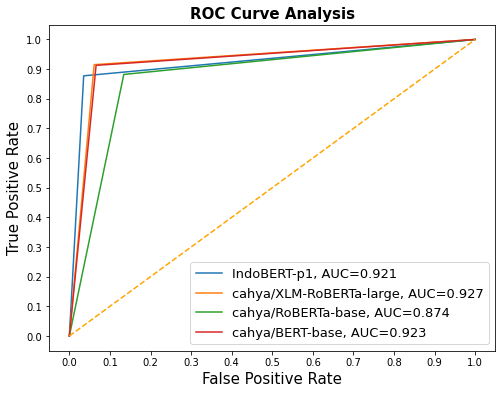

In [108]:
import numpy as np


fig = plt.figure(figsize=(8,6))

for i in result_table_valid.index:
    plt.plot(result_table_valid.loc[i]['fpr'], 
             result_table_valid.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table_valid.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [112]:
result_table.drop(result_table.columns[0], axis=1, inplace=True)

In [113]:
result_table.set_index('classifiers', inplace=True)

In [114]:
result_table = result_table.applymap(lambda x : [ float(i) for i in x.replace('[','').replace(']','').replace(',','').split(' ') if i!= ''] if isinstance(x, str) else x)

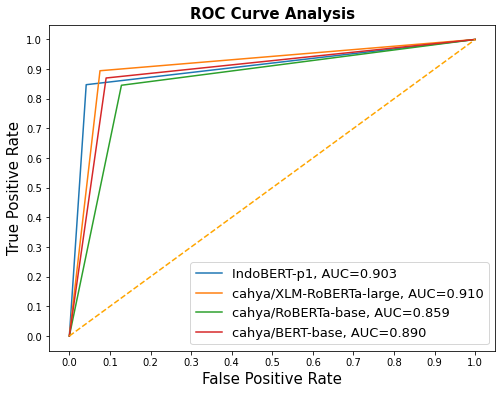

In [115]:
import numpy as np


fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()